# Transfer learning

We will load a pretrained model (our model trained on MNIST) and fine-tune it on the more complex KMNIST dataset http://codh.rois.ac.jp/kmnist/index.html.en (https://github.com/rois-codh/kmnist)


![](kmnist.png)

We also address the following question:
- how different are the two datasets?

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [8]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
from matplotlib import pyplot as plt

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [10]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [11]:
input_size=(1,28,28,)
batch_size=64
test_batch_size=1000
seed=1101

In [12]:
use_cuda = torch.cuda.is_available()
torch.manual_seed(seed)
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

In [13]:
train_loader = torch.utils.data.DataLoader(
        datasets.KMNIST('../data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
        datasets.KMNIST('../data', train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=test_batch_size, shuffle=True, **kwargs)

In [14]:
model = Net().to(device)

In [15]:
model.load_state_dict(torch.load('mnist_cnn.pt'))
model.eval()

Net(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [16]:
inputs,labels = next(iter(test_loader))

In [17]:
inputs.shape

torch.Size([1000, 1, 28, 28])

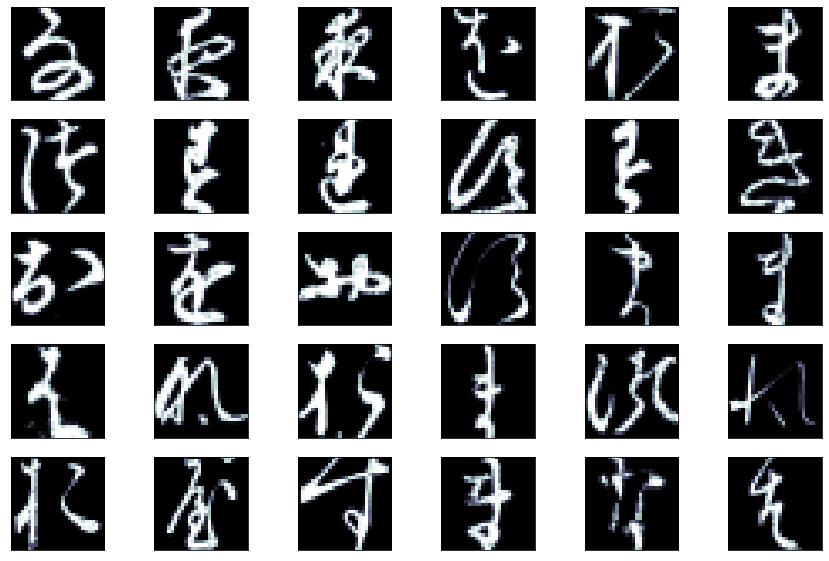

In [18]:
fig=plt.figure(figsize=(15,10))
for i in range(30):
    plt.subplot(5,6,i+1)
    plt.imshow(np.squeeze(inputs[i]),cmap='bone')
    plt.xticks([])
    plt.yticks([])

In [19]:
output = model(inputs)
pred = output.argmax(dim=1, keepdim=True) 
correct = pred.eq(labels.view_as(pred)).sum().item()
print('acc = {}'.format(correct/inputs.shape[0]) )

acc = 0.109


In [20]:
# ... from our Net class
#self.fc1 = nn.Linear(4*4*50, 500)
#self.fc2 = nn.Linear(500, 10)

In [21]:
for p in model.parameters():
    print(p.shape)

torch.Size([20, 1, 5, 5])
torch.Size([20])
torch.Size([50, 20, 5, 5])
torch.Size([50])
torch.Size([500, 800])
torch.Size([500])
torch.Size([10, 500])
torch.Size([10])


In [22]:
for p in model.parameters():
    p.requires_grad = False

In [23]:
list(model.parameters())[-2]

Parameter containing:
tensor([[ 0.0410,  0.0161,  0.0381,  ..., -0.0339,  0.0067, -0.0094],
        [ 0.0445,  0.0248, -0.0228,  ...,  0.0333,  0.0092,  0.0311],
        [-0.0176,  0.0106,  0.0179,  ...,  0.0553, -0.0724, -0.0165],
        ...,
        [ 0.0313,  0.0275,  0.0140,  ...,  0.0164, -0.0206,  0.0390],
        [-0.0506, -0.0433, -0.0182,  ...,  0.0177,  0.0227, -0.0214],
        [-0.0292,  0.0231,  0.0141,  ..., -0.0283, -0.0264, -0.0248]])

In [24]:
model.fc2 = nn.Linear(500,10)

In [25]:
for p in model.parameters():
    print(p.requires_grad)

False
False
False
False
False
False
True
True


In [26]:
list(model.parameters())[-2]

Parameter containing:
tensor([[ 0.0223, -0.0193, -0.0438,  ..., -0.0146, -0.0157,  0.0031],
        [-0.0394,  0.0373, -0.0102,  ..., -0.0152, -0.0076, -0.0126],
        [-0.0379, -0.0072, -0.0297,  ...,  0.0055,  0.0132,  0.0221],
        ...,
        [ 0.0419,  0.0092, -0.0180,  ..., -0.0376, -0.0411, -0.0334],
        [ 0.0092,  0.0259, -0.0270,  ..., -0.0206, -0.0256, -0.0142],
        [-0.0407,  0.0393,  0.0346,  ...,  0.0093,  0.0034,  0.0002]],
       requires_grad=True)

In [27]:
for p in model.parameters():
    print(p.shape,p.requires_grad)

torch.Size([20, 1, 5, 5]) False
torch.Size([20]) False
torch.Size([50, 20, 5, 5]) False
torch.Size([50]) False
torch.Size([500, 800]) False
torch.Size([500]) False
torch.Size([10, 500]) True
torch.Size([10]) True


In [30]:
epochs=1
lr=0.01
momentum=0.0
seed=1
log_interval=100
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
save=False

In [31]:
for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    
if save:
    torch.save(model.state_dict(),"kmnist_trans_fc2.pt")

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.444996
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.465772
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.579393
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.536480
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.530591
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.663410
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.547717
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.610946
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.370897
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.382988

Test set: Average loss: 0.8936, Accuracy: 7239/10000 (72%)



# Exercise

Experiment *freely* with these topics (the only mandatory is the second one):

- extension of random initialization to the second last hidden layer
- monitor test and train loss and accuracy: does the model overfit?
- change learning rate and/or momentum
- regularize it with dropout (*)

(*) You will have to redefine the Net class, adding the dropout layers after the feature extractions (after the second max pooling layer) and after fully connected fc1. Take inspiration from this architecture https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py (which is written in Keras, by the way). Then you have to re-train the model on MNIST and experiment again with transfer learning on KMNIST.

# Intrinsic dimensionality


*You may want to come back to this after Alberto Cazzaniga's Part!*

Let's see how different these two datasets are. We look at their intrinsic dimension. Let us make a guess:
what is the ID of MNIST? and that of KMNIST?

In [24]:
nsamples=5000
sampleKMNISTloader = torch.utils.data.DataLoader(
        datasets.KMNIST('../data', train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=nsamples, shuffle=True, **kwargs)

sampleMNISTloader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=nsamples, shuffle=True, **kwargs)

In [25]:
sample_kmnist,_ = next(iter(sampleKMNISTloader))
sample_mnist,_ = next(iter(sampleMNISTloader))

In [26]:
from intrinsic_dimension import estimate,block_analysis

In [27]:
print(sample_kmnist.shape)
print(sample_mnist.shape)

torch.Size([5000, 1, 28, 28])
torch.Size([5000, 1, 28, 28])


In [28]:
sample_kmnist = np.reshape(np.squeeze(sample_kmnist), (nsamples, -1) )
sample_mnist = np.reshape(np.squeeze(sample_mnist), (nsamples, -1) )

In [29]:
from scipy.spatial.distance import pdist,squareform

In [30]:
#?estimate

In [31]:
kmnist_est = estimate(squareform(pdist(sample_kmnist)), verbose=True)
mnist_est = estimate(squareform(pdist(sample_mnist)), verbose=True)

Found n. 0 elements for which r1 = 0
[]
Found n. 0 elements for which r1 = r2
[]
Fraction good points: 1.0
Found n. 0 elements for which r1 = 0
[]
Found n. 0 elements for which r1 = r2
[]
Fraction good points: 1.0


In [32]:
print(kmnist_est[2])

17.046234115673734


In [33]:
print(mnist_est[2])

12.755779418284677


In [34]:
?block_analysis

In [35]:
kmnist_ba = block_analysis(squareform(pdist(sample_kmnist)))
mnist_ba = block_analysis(squareform(pdist(sample_mnist)))

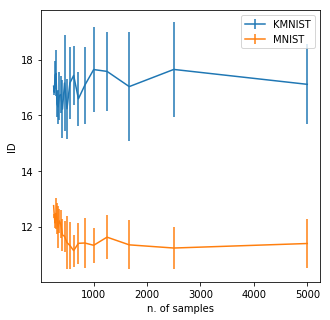

In [36]:
fig=plt.figure(figsize=(5,5))
plt.errorbar(kmnist_ba[2][::-1],kmnist_ba[0],yerr=kmnist_ba[1],label='KMNIST')
plt.errorbar(mnist_ba[2][::-1],mnist_ba[0],yerr=mnist_ba[1],label='MNIST')
plt.xlabel('n. of samples')
plt.ylabel('ID')
plt.legend()
plt.savefig('KMNIST_ID.png')
plt.show()

# Readings

- https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
- https://towardsdatascience.com/getting-started-with-google-colab-f2fff97f594c

# Excercise

Run the notebook on colab and play with it